In [18]:
import json
from pathlib import Path
from src.cross_validation import parse_cd_hit_clusters
from rdkit import Chem
from tqdm import tqdm
from collections import Counter
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
)
import matplotlib.pyplot as plt
from src.ergochemics.draw import draw_molecule, draw_reaction
from IPython.display import SVG

In [21]:
def rc_to_nest(rc: str) -> tuple[tuple[tuple[int]]]:
    '''
    Convert string representation of reaction center to nested tuple representation.
    '''
    return tuple(
        tuple(
            tuple(
                int(aidx) for aidx in mol.split(",") if aidx != ""
            )
            for mol in side.split(";")
        )
        for side in rc.split(">>")
    )

In [10]:
def quick_roc(fp: str):
    df = pd.read_parquet(fp)
    score = roc_auc_score(df['y'], df['logits'])
    return score

In [ ]:
# Trained on rc split data (missing 20% of rcs therefore...) which has arc negs. Test neg samples are ARC
run_ids = {
    "rc_agg": "7446e660756f4cf486a9b17372880abf",
    "cgr": "a20a704601954d8983435696493f7638",
    "bom": "8f3e92d3688c4eaaa754c03f821a5f50",
    "mfp": "312b2ccd7ab8476eaf2f02559b472f37"

}
fps = {
    k: f"/home/stef/quest_data/hiec/results/predictions/{run_id}/time_split_alternate_reaction_center_target_output.parquet"
    for k, run_id in run_ids.items()

}
for k, fp in fps.items():
    score = quick_roc(fp)
    print(f"{k}: {score}")

rc_agg: 0.7874361793960847
cgr: 0.7748261878115119
bom: 0.9174610352710504
mfp: 0.8231988979694529


In [ ]:
# ***
# Trained on random rxn split data - better stratified- which has arc negs. Test neg samples are ARC
run_ids = {
    "rc_agg": "7f9e852795664f9d877f9c0b05ee4177",
    "rc_cxn": "575b67f3c7ac4d3b896a5a6e2ecf9350",
    "cgr": "e8554547daa542a091131c518dcf002a",
    "bom": "e35758e78f444ffcb352891483f11dcd",
    "mfp": "ac4018e22f994c26921bc3a3a0797d58"

}
fps = {
    k: f"/home/stef/quest_data/hiec/results/predictions/{run_id}/time_split_alternate_reaction_center_target_output.parquet"
    for k, run_id in run_ids.items()

}
for k, fp in fps.items():
    score = quick_roc(fp)
    print(f"{k}: {score}")

rc_agg: 0.7973699892421343
rc_cxn: 0.8159367964551097
cgr: 0.8706885847333741
bom: 0.8437277685236998
mfp: 0.8424805013685914


In [ ]:
# ***
# Trained on rcmcs split, which is better stratified, and has random negs. Test neg samples are random
run_ids = {
    "rc_agg": "8a155bc5673b4c6aa8667dd55755fe0b",
    "rc_cxn": "5ca6ba7b8aec4b81a366e9138b9c09b0",
    "cgr": "2a7b803f790143f0b14a1955117cb393",
    "bom": "ff90895a6070499b8fdcdc0982526885",
    "mfp": "fb3c7a9061a744fba7dabf9d50092414"

}
fps = {
    k: f"/home/stef/quest_data/hiec/results/predictions/{run_id}/time_split_random_target_output.parquet"
    for k, run_id in run_ids.items()

}
for k, fp in fps.items():
    score = quick_roc(fp)
    print(f"{k}: {score}")

rc_agg: 0.7698837232199117
rc_cxn: 0.8777265805503046
cgr: 0.8072079788909893
bom: 0.8790687027410208
mfp: 0.8555173217286285


In [63]:
# Trained on rcmcs split, which is better stratified, and has random negs. Test neg samples are ARC
run_ids = {
    "rc_agg": "8a155bc5673b4c6aa8667dd55755fe0b",
    "cgr": "2a7b803f790143f0b14a1955117cb393",
    "bom": "ff90895a6070499b8fdcdc0982526885",
    "mfp": "fb3c7a9061a744fba7dabf9d50092414"

}
fps = {
    k: f"/home/stef/quest_data/hiec/results/predictions/{run_id}/time_split_alternate_reaction_center_target_output.parquet"
    for k, run_id in run_ids.items()

}
for k, fp in fps.items():
    score = quick_roc(fp)
    print(f"{k}: {score}")

rc_agg: 0.5570188566297516
cgr: 0.4409893928746491
bom: 0.4696709795730689
mfp: 0.6693223791800598


In [41]:
# Trained on random rxn split data - better stratified- which has arc negs. Test neg samples are random
run_ids = {
    "rc_agg": "7f9e852795664f9d877f9c0b05ee4177",
    "cgr": "e8554547daa542a091131c518dcf002a",
    "bom": "e35758e78f444ffcb352891483f11dcd",
    "mfp": "ac4018e22f994c26921bc3a3a0797d58"

}
fps = {
    k: f"/home/stef/quest_data/hiec/results/predictions/{run_id}/time_split_random_target_output.parquet"
    for k, run_id in run_ids.items()

}
for k, fp in fps.items():
    score = quick_roc(fp)
    print(f"{k}: {score}")

rc_agg: 0.4683911271266541
cgr: 0.4621150362318841
bom: 0.5756791837324092
mfp: 0.5389776635685781


In [14]:
fp = "/home/stef/quest_data/hiec/results/predictions/7446e660756f4cf486a9b17372880abf/time_split_random_target_output.parquet"
score = quick_roc(fp)
print(f"rc_agg random: {score}")

rc_agg random: 0.47093868147448015


In [16]:

fp = "/home/stef/quest_data/hiec/results/predictions/8a155bc5673b4c6aa8667dd55755fe0b/time_split_random_target_output.parquet"
score = quick_roc(fp)
print(f"rc_agg random: {score}")

rc_agg random: 0.7698837232199117


In [20]:
new_rxns = pd.read_csv("/home/stef/quest_data/hiec/data/time_split/250915_sprhea_time_split_raw.tsv", sep="\t")
new_rxns.head()

,id,sequence,existence,reviewed,ec,organism,name,subunit,rxn_id,reverse,db_ids,rhea_idx,smarts,am_smarts,rule,template_aidxs,rule_id,rev_rxn_id,rev_rule_id
0,Q9VXN0,MSCAKPHILIIEPFYGGSHKQLIGALIEGLNHGDSEIFSLPAKKWH...,Evidence at transcript level,reviewed,2.4.1.110,Drosophila melanogaster (Fruit fly),tRNA-queuosine alpha-mannosyltransferase (EC 2...,False,c19cf7ba78299fcf7054ef7cf86e7ce4d52a44d7,*OC1C(COP(*)(=O)O)OC(n2cc(CNC3C=CC(OC4OC(CO)C(...,RHEA:12886,690,Nc1nc2c(ncn2C2OC(COP(=O)(O)OP(=O)(O)OC3OC(CO)C...,[NH2:71][c:69]1[n:67][c:65]2[c:68]([n:66][cH:6...,[#6:1]-[#8:2].[#8:3]>>[#6:1]-[#8:3].[#8:2],"21,20;21>>21,22;19",517,0742ced3ba6b05ecd49fac26a95afcb5ac35f850,517
1,P26403,MKITLIIPTYNAGSLWPNVLDAIKQQTIYPDKLIVIDSGSKDETVP...,Evidence at protein level,reviewed,2.4.1.377,Salmonella typhimurium (strain LT2 / SGSC1412 ...,O-antigen chain rhamnosyltransferase RfbN (EC ...,False,3bf629a530f9a2f3a568796888146af735cd814d,CC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCCC(C)=...,RHEA:66953,13619,Cc1cn(C2CC(O)C(COP(=O)(O)OP(=O)(O)OC3OC(C)C(O)...,[CH3:108][c:105]1[cH:103][n:102]([CH:101]2[CH2...,[#6:1]-[#8:2].[#8:3]>>[#6:1]-[#8:3].[#8:2],"19,18;72>>72,73;17",517,670bb65c1cf604c9bc1676fa7ca0c93585d2c5e2,517
2,G3UYQ4,MASEEKTEELHPFTDIFNEDETDRNCLLSKPTCFIIFGKPGAGKTT...,Evidence at transcript level,reviewed,2.7.4.4; 2.7.4.6,Mus musculus (Mouse),Adenylate kinase 9 (EC 2.7.4.4) (EC 2.7.4.6),False,e94fa89a1f352a07afd07e79cb4fefe563629328,Nc1nc2c(ncn2C2OC(COP(=O)(O)OP(=O)(O)O)C(O)C2O)...,RHEA:79864,16809,O=c1ccn(C2OC(COP(=O)(O)OP(=O)(O)O)C(O)C2O)c(=O...,[O:54]=[c:53]1[cH:50][cH:48][n:46]([CH:43]2[O:...,[#8:1].[#8:2]-[#15:3]>>[#8:2].[#8:1]-[#15:3],"16;20,21>>19;17,18",637,c71a7c603f5c77b97f9ed153872bce346110c573,637
3,Q5FVH2,MKPKLMYQELKVPVEEPAGELPMNEIEAWKAAEKKARWVLLVLILA...,Evidence at protein level,reviewed,3.1.16.1; 3.1.4.-,Rattus norvegicus (Rat),"5'-3' exonuclease PLD3 (EC 3.1.16.1) ((S,S)-bi...",False,9c806f5e2fd3b2bd22f529ff066393dcdb09c79f,CCCCCCCCC=CCCCCCCCC(=O)OCC(O)CO.CCCCCCCCC=CCCC...,RHEA:82569,17412,CCCCCCCCC=CCCCCCCCC(=O)OCC(O)COP(=O)(O)OCC(O)C...,[CH3:20][CH2:19][CH2:18][CH2:17][CH2:16][CH2:1...,[#6:1]-[#8:2].[#8:3]>>[#6:1]-[#8:3].[#8:2],"17,19;0>>17,19;33",517,a7a00609de5efcc60e30fb77f10922af59fbdbaf,517
4,J9VPA2,MAFAGVGQGLGTYDRTEQTSGASLGRVASRAHFTDTHPSDDLPAQT...,Evidence at protein level,reviewed,NaN,Cryptococcus neoformans var. grubii serotype A...,ABC multidrug transporter AFR2,False,23281d7a637c745f1978c29d20b03cdf6bd5931b,CC(c1ncncc1F)C(O)(Cn1cncn1)c1ccc(F)cc1F.Nc1ncn...,RHEA:61914,12377,CC(c1ncncc1F)C(O)(Cn1cncn1)c1ccc(F)cc1F.Nc1ncn...,[CH3:6][CH:3]([c:7]1[n:11][cH:18][n:24][cH:19]...,[#6:1]-[#8:2].[#8:3].[#8:4]-[#15:5]>>[#6:1]-[#...,"9,10;21;2,1>>9,10;0;22,23",607,77a9b2f20f10b17985b01d0edcdfbfc631542523,228


In [ ]:
i = 6

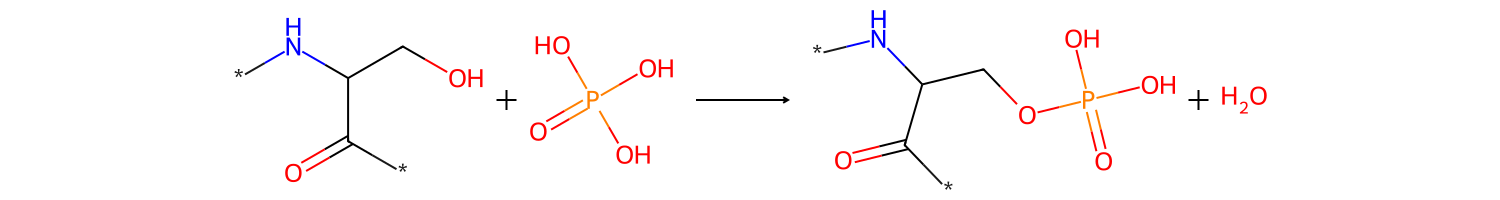

Reactants:


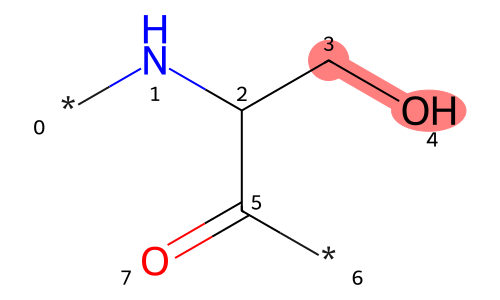

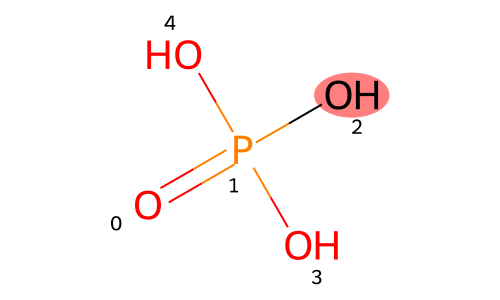

Products:


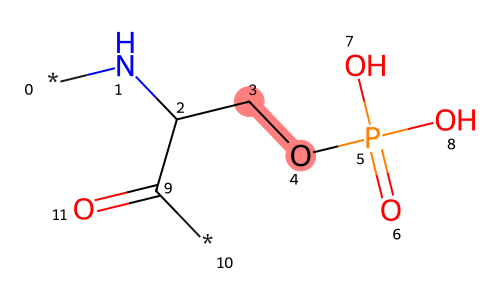

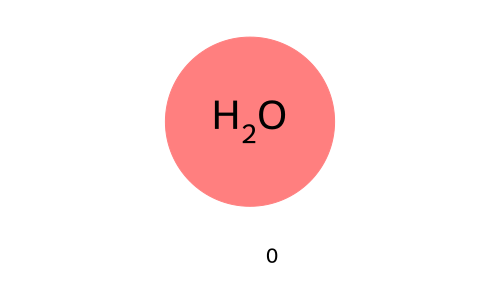

In [60]:
i += 1
smarts = new_rxns.loc[i, 'smarts']
rcs = rc_to_nest(new_rxns.loc[i, 'template_aidxs'])
display(SVG(draw_reaction(smarts)))
rcts, pdts = [side.split(".") for side in smarts.split(">>")]

print("Reactants:")
for rct, rc in zip(rcts, rcs[0]):
    display(SVG(draw_molecule(rct, highlight_atoms=[aidx for aidx in rc], draw_options={'addAtomIndices': True}, size=(500, 300))))

print("Products:")
for pdt, rc in zip(pdts, rcs[1]):
    display(SVG(draw_molecule(pdt, highlight_atoms=[aidx for aidx in rc], draw_options={'addAtomIndices': True}, size=(500, 300))))

In [23]:
rc

(((21, 20), (21,)), ((21, 22), (19,)))

In [2]:
dir = "/home/stef/hiec/artifacts/clustering"
dataset = 'sprhea'
toc = 'v3_folded_pt_ns'
strats = ['rcmcs', 'esm', 'gsi', 'blosum']
cutoffs = [
    (80, 60, 40),
    (99, 98, 97, 95),
    (35, 30, 25),
    (80, 60, 40)
]

In [3]:
for strat, cuts in zip(strats, cutoffs):
    for c in cuts:
        path = Path(dir) / f"{dataset}_{toc}_{strat}_{c}.json"
        with open(path) as f:
            data = json.load(f)

        print(f"{strat} {c}: {len(set(data.values()))}")

rcmcs 80: 2528
rcmcs 60: 1351
rcmcs 40: 758
esm 99: 9382
esm 98: 5768
esm 97: 3310
esm 95: 691
gsi 35: 8332
gsi 30: 2656
gsi 25: 334
blosum 80: 716
blosum 60: 72
blosum 40: 69


In [78]:
def score(x : np.ndarray) -> float:
    return sum(x) / len(x)

def bootstrap_score(metric: callable) -> callable:
    def f(x : np.ndarray, *args) -> tuple[float, float]:
        scores = []
        for _ in range(5):
            idx = np.random.choice(len(x), len(x), replace=True)
            scores.append(metric(x[idx], *args))

        return metric(x), np.std(scores)
    return f

bs_score = bootstrap_score(score)

x = np.array([1, 0, 1, 1, 0, 1, 0, 1, 1, 0])
bs_score(x)
            

(np.float64(0.6), np.float64(0.10198039027185568))

In [5]:
fn = '/projects/p30041/spn1560/hiec/results/predictions/clipzyme/sprhea_v3_folded_pt_ns_rcmcs_outer_fold/target_output.parquet'
df = pd.read_parquet(fn)
df.head()

,protein_idx,reaction_idx,pid,rid,y,logits
0,16113,5226,Q09KQ6,16449,1,0.643928
1,21408,5226,Q9CZU6,16449,0,0.586794
2,7098,5226,Q5XI78,16449,0,0.496528
3,11061,5226,Q8RXV3,16449,0,0.494431
4,24151,5226,O30418,16449,0,0.567291


In [6]:
(df['y'] == (df['logits'] > 0.5)).mean()

np.float64(0.724076837001119)

In [7]:
roc_auc_score(df['y'], df['logits'])

0.7279638045220533

In [8]:
df['y'].mean(), len(df)

(np.float64(0.4842409548675867), 10724)

In [9]:
fn2 = '/projects/p30041/spn1560/hiec/results/predictions/8a155bc5673b4c6aa8667dd55755fe0b/target_output.parquet'
df2 = pd.read_parquet(fn2)
df2.head()

,protein_idx,reaction_idx,pid,rid,y,logits
0,16113,5226,Q09KQ6,16449,1,9.999980e-01
1,21408,5226,Q9CZU6,16449,0,2.327771e-08
2,7098,5226,Q5XI78,16449,0,1.028115e-11
3,11061,5226,Q8RXV3,16449,0,6.455649e-12
4,24151,5226,O30418,16449,0,1.486794e-10


In [10]:
roc_auc_score(df2['y'], df2['logits'])

0.9611057129009355

In [11]:
pairs = set(zip(df['protein_idx'], df['reaction_idx']))
pairs2 = set(zip(df2['protein_idx'], df2['reaction_idx']))
pairs ^ pairs2

set()

In [12]:
pairs = set(zip(df['pid'], df['rid']))
pairs2 = set(zip(df2['pid'], df2['rid']))
pairs ^ pairs2

set()

In [28]:
fni = '/projects/p30041/spn1560/hiec/results/predictions/95963b479bb9434ba0c4fb43a05dc7a4/target_output.parquet'
dfi = pd.read_parquet(fni)
dfi.head()

,protein_idx,reaction_idx,pid,rid,y,logits
0,222,187,Q9KJ20,7694,1,0.999964
1,223,187,Q83WC3,7694,1,0.999654
2,224,187,Q9KJ21,7694,1,0.998847
3,13363,187,Q9KJ22,7694,1,0.999877
4,13364,187,Q7U4Z8,7694,1,0.999670


In [30]:
roc_auc_score(dfi['y'], dfi['logits'])

0.9548395691667799

In [13]:
fnbn = '/projects/p30041/spn1560/hiec/results/predictions/clip_torch_bn/sprhea_v3_folded_pt_ns_rcmcs_outer_fold/target_output.parquet'
dfbn = pd.read_parquet(fnbn)
dfbn.head()

,protein_idx,reaction_idx,pid,rid,y,logits
0,16113,5226,Q09KQ6,16449,1,9.986486e-01
1,21408,5226,Q9CZU6,16449,0,1.045536e-04
2,7098,5226,Q5XI78,16449,0,1.836148e-07
3,11061,5226,Q8RXV3,16449,0,1.734039e-11
4,24151,5226,O30418,16449,0,9.811359e-01


In [14]:
roc_auc_score(dfbn['y'], dfbn['logits'])

0.9147337122629683

In [31]:
fni2 = '/projects/p30041/spn1560/hiec/results/predictions/clipzyme/sprhea_v3_folded_pt_ns_rcmcs_inner_fold_1_of_3/target_output.parquet'
dfi2 = pd.read_parquet(fni2)
dfi2.head()

,protein_idx,reaction_idx,pid,rid,y,logits
0,222,187,Q9KJ20,7694,1,0.707570
1,223,187,Q83WC3,7694,1,0.698980
2,224,187,Q9KJ21,7694,1,0.700994
3,13363,187,Q9KJ22,7694,1,0.649789
4,13364,187,Q7U4Z8,7694,1,0.624836


In [32]:
roc_auc_score(dfi2['y'], dfi2['logits'])

0.9051656582995725

<Axes: xlabel='epoch'>

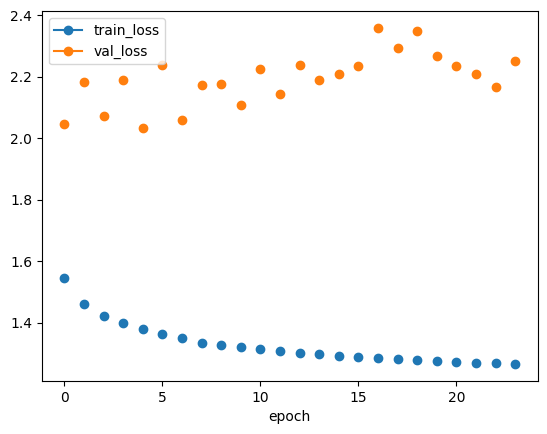

In [15]:
fn = '/projects/p30041/spn1560/hiec/results/runs/clip_torch_bn/sprhea_v3_folded_pt_ns_rcmcs_outer_fold/metrics.csv'
df = pd.read_csv(fn)
df.plot(x='epoch', y=['train_loss', 'val_loss'], marker='o')

In [ ]:
df = pd.read_csv("/home/stef/hiec/artifacts/251015_non_clip_v2_split_models.csv")
df.head()

In [ ]:
_run_ids = []
for name, gb in df.groupby(['data/split_strategy', 'model/name']):
    if len(gb.loc[gb['data/split_idx'] == 0]) == 0:
        inner_run_id = "TODO"
    else:
        inner_run_id = gb.loc[gb['data/split_idx'] == 0, 'Run ID'].values[0]
        _run_ids.append(inner_run_id)
    outer_run_id = gb.loc[gb['data/split_idx'] == -1, 'Run ID'].values[0]
    print(f"{outer_run_id}: {inner_run_id} # Model: {name[1]}, Split strat: {name[0]}")
    _run_ids.append(outer_run_id)

In [ ]:
for elt in _run_ids:
    print(elt)